In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "fake-news-detection-dataset"

# **Table of Contents**
------------------
✅ **Load Libraries.**   
✅ **Import Data.**   
✅ **Data Transfromation & EDA.**   
✅ **Data Visualization.**   
✅ **ML Modeling & Prediction.**   

# **1. Load Libraries**

In [2]:
library(tidyverse)
library(tidymodels)
library(psych)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(ggcorrplot)
library(GGally)
library(lubridate)

########################
library(tm)
library(twitteR)
library(SnowballC)
library(wordcloud)
library(stringr)

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6      ✔ rsample      1.2.1 
✔ dials        1.2.1      ✔ tune         1.2.1 
✔ infer        1.0.7      ✔ workflows    1.1.4 
✔ modeldata    1.4.0      ✔ workflowsets 1.1.0 
✔ parsnip      1.2.1      ✔ yardstick    1.3.1 
✔ recipes      1.0.10     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use tidymodels_prefer() to resolve common conflicts.


Attaching package: ‘psych’


The following objects are masked from ‘package:scales’:

    alpha, rescale


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dply

# **2. Import Data & EDA.**
----------

In [3]:
df <- read.csv('/kaggle/input/fake-news-detection-dataset/fake_news_dataset.csv', encoding='ascii') %>% janitor::clean_names()

## **Data Description**
--------------
**This file contains a synthetically generated dataset for Fake News Detection tasks.**   
**Each row represents a news article along with associated metadata and a label indicating whether the news is real or fake.**   

* **title**: **The headline or short title of the article.**   
* **text**: **The main body of the news article, written in medium-length text (~200-300 words).**   
* **date**: **The publication date of the article.**   
* **source**: **The media organization that published the article (may contain missing values).**   
* **author**: **The name of the author who wrote the article (may contain missing values).**   
* **category**: **The category to which the article belongs (Politics, Technology, Health, Sports, etc.).**   
* **label**: **The target classification, either real or fake.**   

# **3. Data Transfromation & EDA.**
----------------

In [4]:
# Data Type Conversion 

df$date <- as.Date(df$date)
df$label <- as.factor(df$label)
df$source <- as.factor(df$source)
df$category <- as.factor(df$category)

In [5]:
# Number of characters count (no spaces)

title_clean <- gsub("\\s", "", df$title)
df$title_count <- nchar(title_clean)

text_clean <- gsub("\\s", "", df$text)
df$text_count <- nchar(text_clean)

## **Summary**

In [6]:
glimpse(df)

Rows: 20,000
Columns: 9
$ title       <chr> "Foreign Democrat final.", "To offer down resource great p…
$ text        <chr> "more tax development both store agreement lawyer hear out…
$ date        <date> 2023-03-10, 2022-05-25, 2022-09-01, 2023-02-07, 2023-04-0…
$ source      <fct> NY Times, Fox News, CNN, Reuters, CNN, Reuters, CNN, NY Ti…
$ author      <chr> "Paula George", "Joseph Hill", "Julia Robinson", "Mr. Davi…
$ category    <fct> Politics, Politics, Business, Science, Technology, Health,…
$ label       <fct> real, fake, fake, fake, fake, real, fake, fake, fake, real…
$ title_count <int> 21, 30, 25, 17, 32, 43, 16, 28, 37, 35, 35, 30, 36, 40, 36…
$ text_count  <int> 1219, 1351, 1251, 1413, 1227, 1497, 1486, 1393, 1614, 1111…


In [7]:
summary(df)

    title               text                date                     source    
 Length:20000       Length:20000       Min.   :2022-04-26   Daily News  :2439  
 Class :character   Class :character   1st Qu.:2023-01-24   BBC         :2393  
 Mode  :character   Mode  :character   Median :2023-10-25   The Guardian:2382  
                                       Mean   :2023-10-24   CNN         :2375  
                                       3rd Qu.:2024-07-25   NY Times    :2372  
                                       Max.   :2025-04-25   Fox News    :2362  
                                                            (Other)     :5677  
    author                   category     label        title_count   
 Length:20000       Business     :2849   fake:10056   Min.   : 8.00  
 Class :character   Entertainment:2889   real: 9944   1st Qu.:24.00  
 Mode  :character   Health       :2922                Median :31.00  
                    Politics     :2802                Mean   :31.47  
          

In [8]:
describe(df)

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
title*,1,20000,10000.50000,5773.6470277,10000.5,10000.500000,7413.0000,1,20000,19999,0.000000000,-1.2001800,40.825849654
text*,2,20000,10000.50000,5773.6470277,10000.5,10000.500000,7413.0000,1,20000,19999,0.000000000,-1.2001800,40.825849654
date,3,20000,NaN,NA,NA,NaN,NA,Inf,-Inf,-Inf,NA,NA,NA
source*,4,20000,5.26505,2.4416586,5.0,5.268813,2.9652,1,9,8,-0.026673864,-1.1861207,0.017265133
author*,5,20000,8119.59790,5120.3788501,8092.5,8103.132812,6572.3658,1,17052,17051,0.012074106,-1.2118987,36.206546072
category*,6,20000,3.99610,2.0039675,4.0,3.995125,2.9652,1,7,6,0.009454072,-1.2575102,0.014170190
label*,7,20000,1.49720,0.5000047,1.0,1.496500,0.0000,1,2,1,0.011199336,-1.9999746,0.003535567
title_count,8,20000,31.47225,9.3511230,31.0,31.236688,10.3782,8,66,58,0.229497861,-0.4675883,0.066122425
text_count,9,20000,1385.93260,164.2545684,1385.0,1385.739875,206.0814,1024,1778,754,0.004016365,-1.1010292,1.161455191


In [9]:
df_skim <- skimr::skim(df)
print(df_skim)

Warning message:
“There was 1 warning in `dplyr::summarize()`.
ℹ In argument: `dplyr::across(tidyselect::any_of(variable_names),
  mangled_skimmers$funs)`.
ℹ In group 0: .
Caused by warning:
! There was 1 warning in `dplyr::summarize()`.
ℹ In argument: `dplyr::across(tidyselect::any_of(variable_names),
  mangled_skimmers$funs)`.
Caused by warning in `sorted_count()`:
! Variable contains value(s) of "" that have been converted to "empty".”


── Data Summary ────────────────────────
                           Values
Name                       df    
Number of rows             20000 
Number of columns          9     
_______________________          
Column type frequency:           
  character                3     
  Date                     1     
  factor                   3     
  numeric                  2     
________________________         
Group variables            None  

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  min  max empty n_unique whitespace
1 title                 0             1   10   73     0    20000          0
2 text                  0             1 1223 2077     0    20000          0
3 author                0             1    0   26  1000    17052          0

── Variable type: Date ─────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate min        max        median    
1 date    

## **Checking Missing Value & Duplicate Value**

In [10]:
na <- data.frame(Na_Count = colSums(is.na(df)))
na

,Na_Count
,<dbl>
title,0
text,0
date,0
source,0
author,0
category,0
label,0
title_count,0
text_count,0


In [11]:
sum(duplicated(df))

[1] 0

In [12]:
head(df, 1)

,title,text,date,source,author,category,label,title_count,text_count
,<chr>,<chr>,<date>,<fct>,<chr>,<fct>,<fct>,<int>,<int>
1,Foreign Democrat final.,more tax development both store agreement lawyer hear outside continue reach difference yeah figure your power fear identify there protect security great national nothing fast story why late nearly bit cost tough since question to power almost future young conference behind ahead building teach million box receive Mrs risk benefit month compare environment class imagine you vote community reason set once idea him answer many how purpose deep training game own true language garden of partner result face military discover discover data glass bed maintain test way development across top culture glass yes decision hope necessary as trade organization talk debate peace stay community development six wide write itself several fight teach billion for common fear we personal church establish store kind hundred debate hotel cut sister audience sound case that stay within information trouble be debate great themselves responsibility force people hundred bar miss others sometimes build room interesting however charge what especially north no especially us travel industry about including face ten behind black series place age soldier early trouble middle would along case what money significant sound song reason poor free want thank cultural range shoulder rest movie political fear hear past leader up edge professor determine law act change middle prove say notice travel open director argue economic seven game matter season,2023-03-10,NY Times,Paula George,Politics,real,21,1219


# **3. Data Visualization**

In [13]:
num_cols <- df %>% select(where(is.numeric)) %>% colnames()
cat_cols <- df %>% select(where(is.factor)) %>% colnames()
cat('num_cols :', num_cols,'\n')
cat('cat_cols :', cat_cols)

num_cols : title_count text_count 
cat_cols : source category label

## **Histogram & Densityplot & Boxplot**

In [14]:
options(repr.plot.width = 20.0, repr.plot.height = 10.0)

Warning message in geom_histogram(aes(x = df[, i]), fill = "skyblue", col = "black", :
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(aes(x = df[, i]), fill = "skyblue", col = "black", :
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


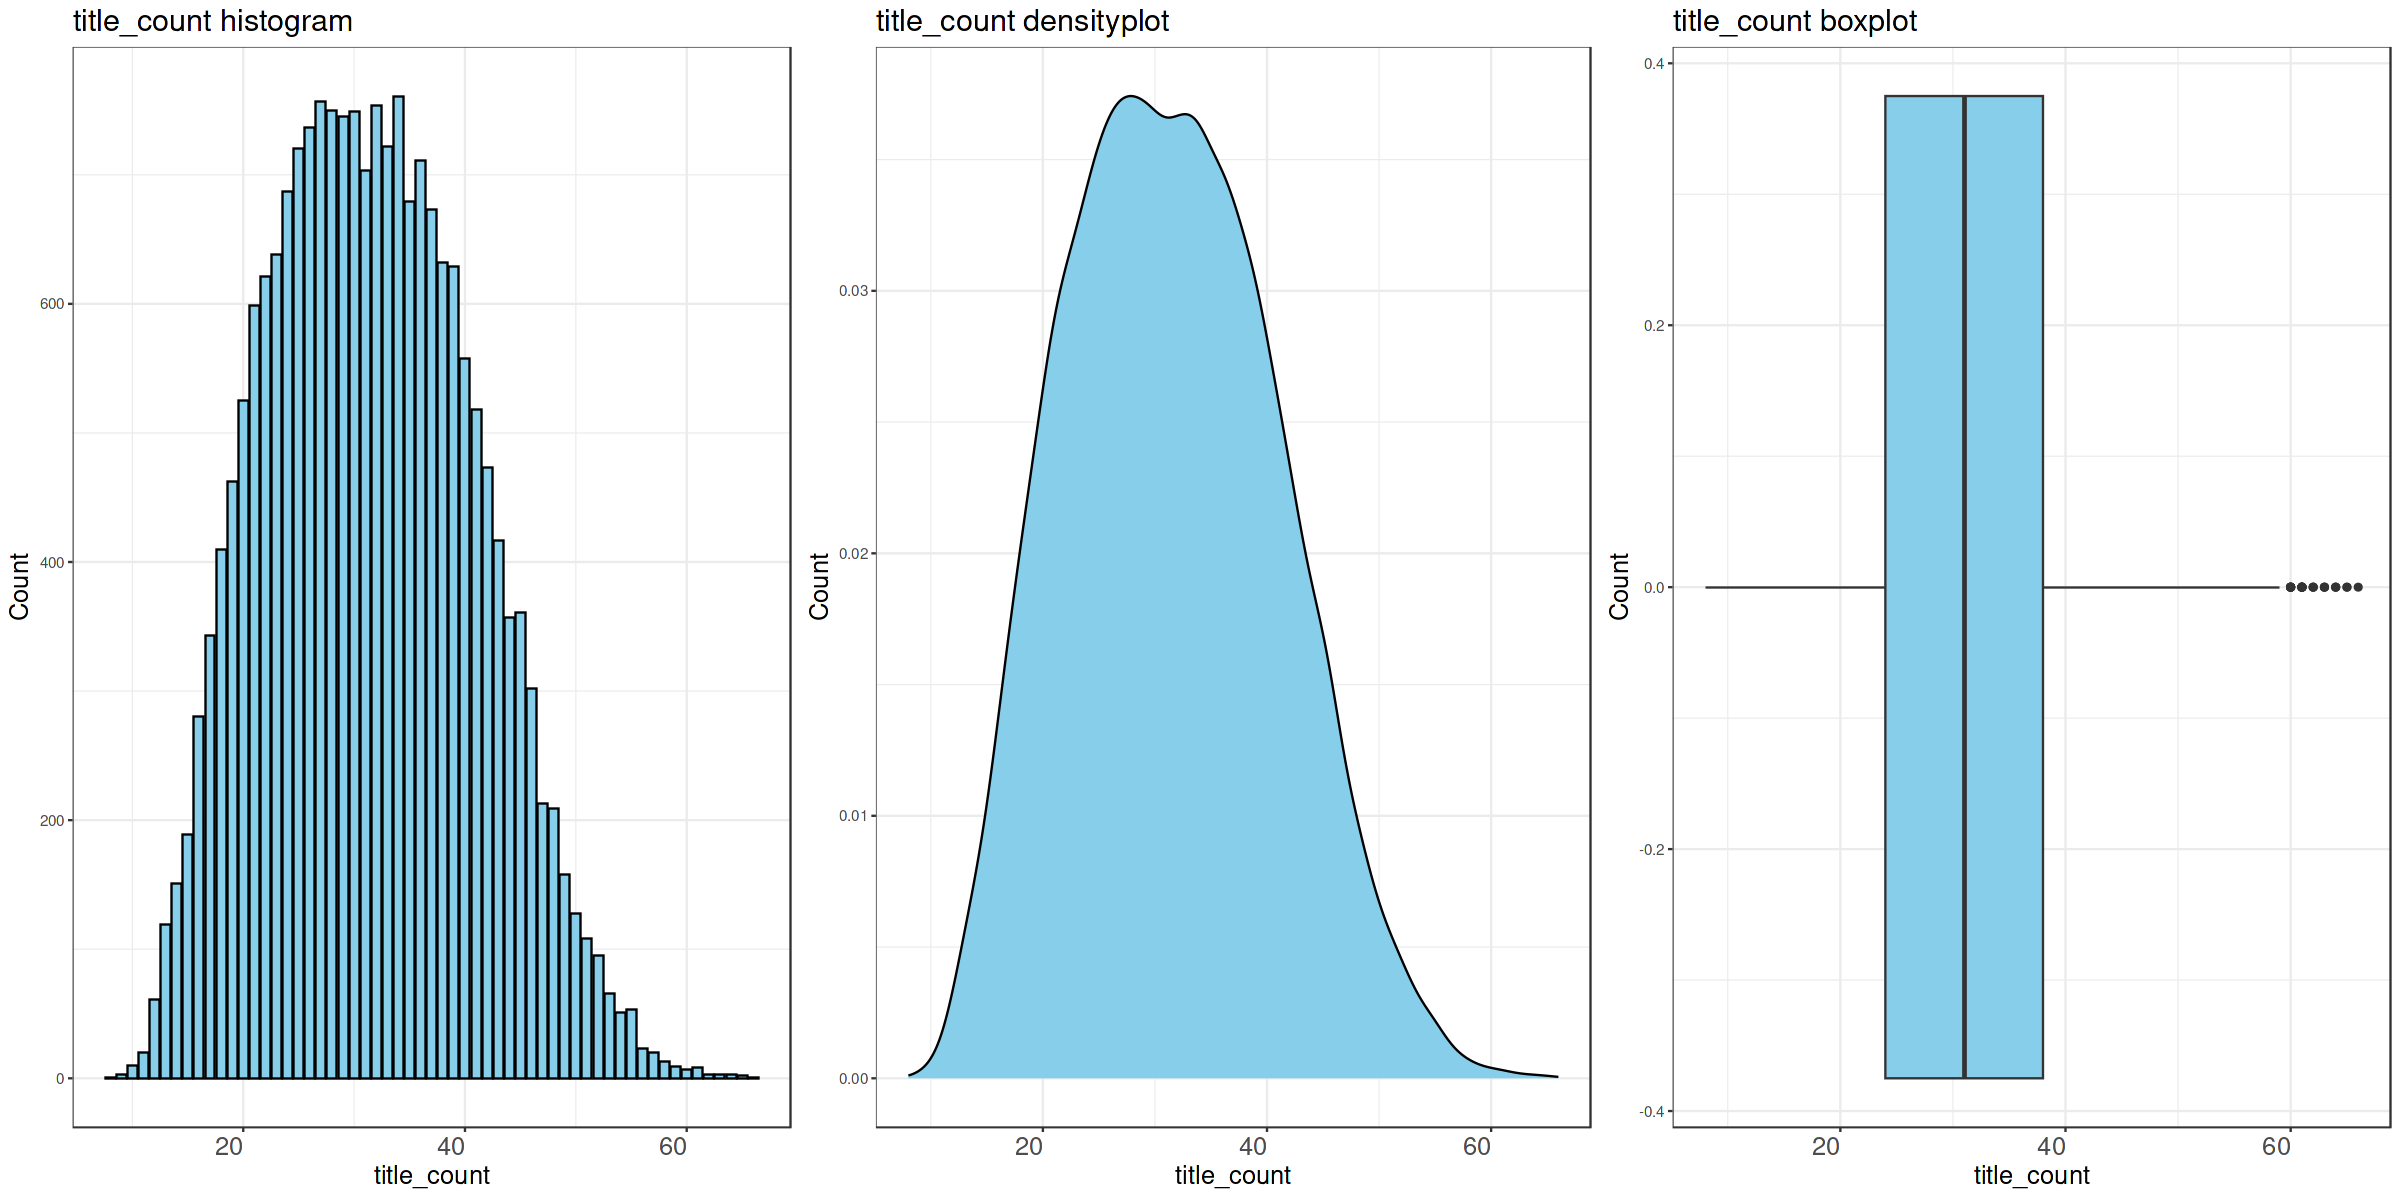

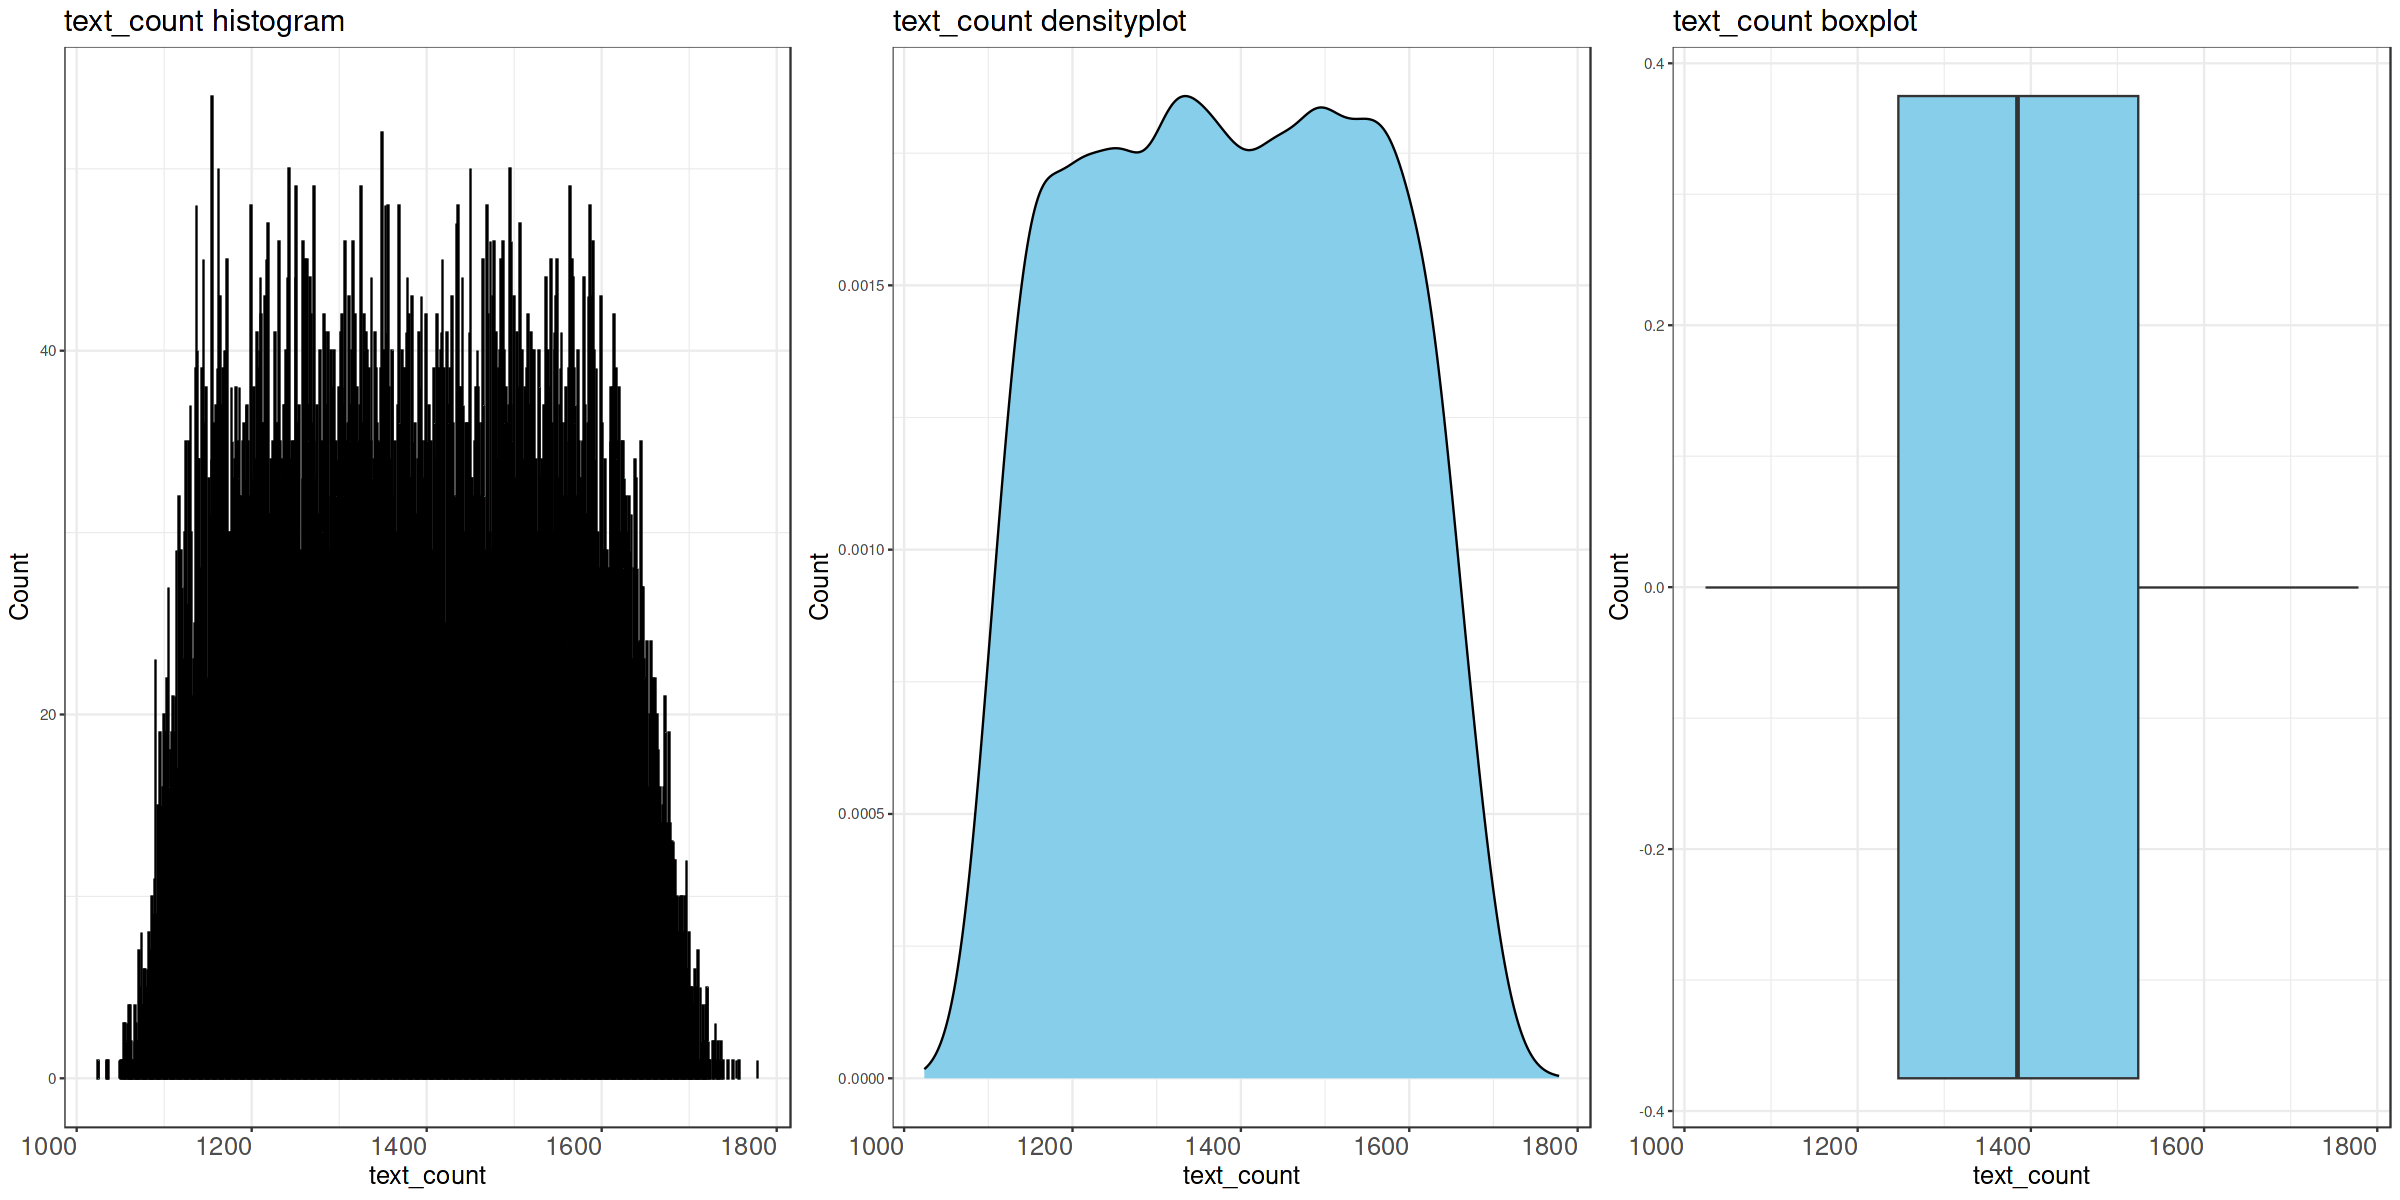

In [15]:
for(i in num_cols){
    a <- ggplot(df) + geom_histogram(aes(x= df[,i]), fill = 'skyblue', col = 'black', position = 'dodge', stat="count" ,bins = 30) + 
            labs(title = paste0(names(df[i]),' histogram'), x = names(df[i]), y = 'Count') + 
            theme_bw() +
            theme(axis.title = element_text(size=15),
            axis.text.x = element_text(size = 15, hjust=1),
            title = element_text(size=15)
            )
    
    b <- ggplot(df) + geom_density(aes(x= df[,i]), fill = 'skyblue') + 
            labs(title = paste0(names(df[i]),' densityplot'), x = names(df[i]), y = 'Count') + 
            theme_bw() +
            theme(axis.title = element_text(size=15),
            axis.text.x = element_text(size = 15, hjust=1),
            title = element_text(size=15)
            ) 
    
    c <- ggplot(df) + geom_boxplot(aes(x= df[,i]), fill = 'skyblue') + 
            labs(title = paste0(names(df[i]),' boxplot'), x = names(df[i]), y = 'Count') + 
            theme_bw() +
            theme(axis.title = element_text(size=15),
            axis.text.x = element_text(size = 15, hjust=1),
            title = element_text(size=15)
            )    
    
    grid.arrange(a,b, c, ncol = 3)    
}

## **Count Plot**

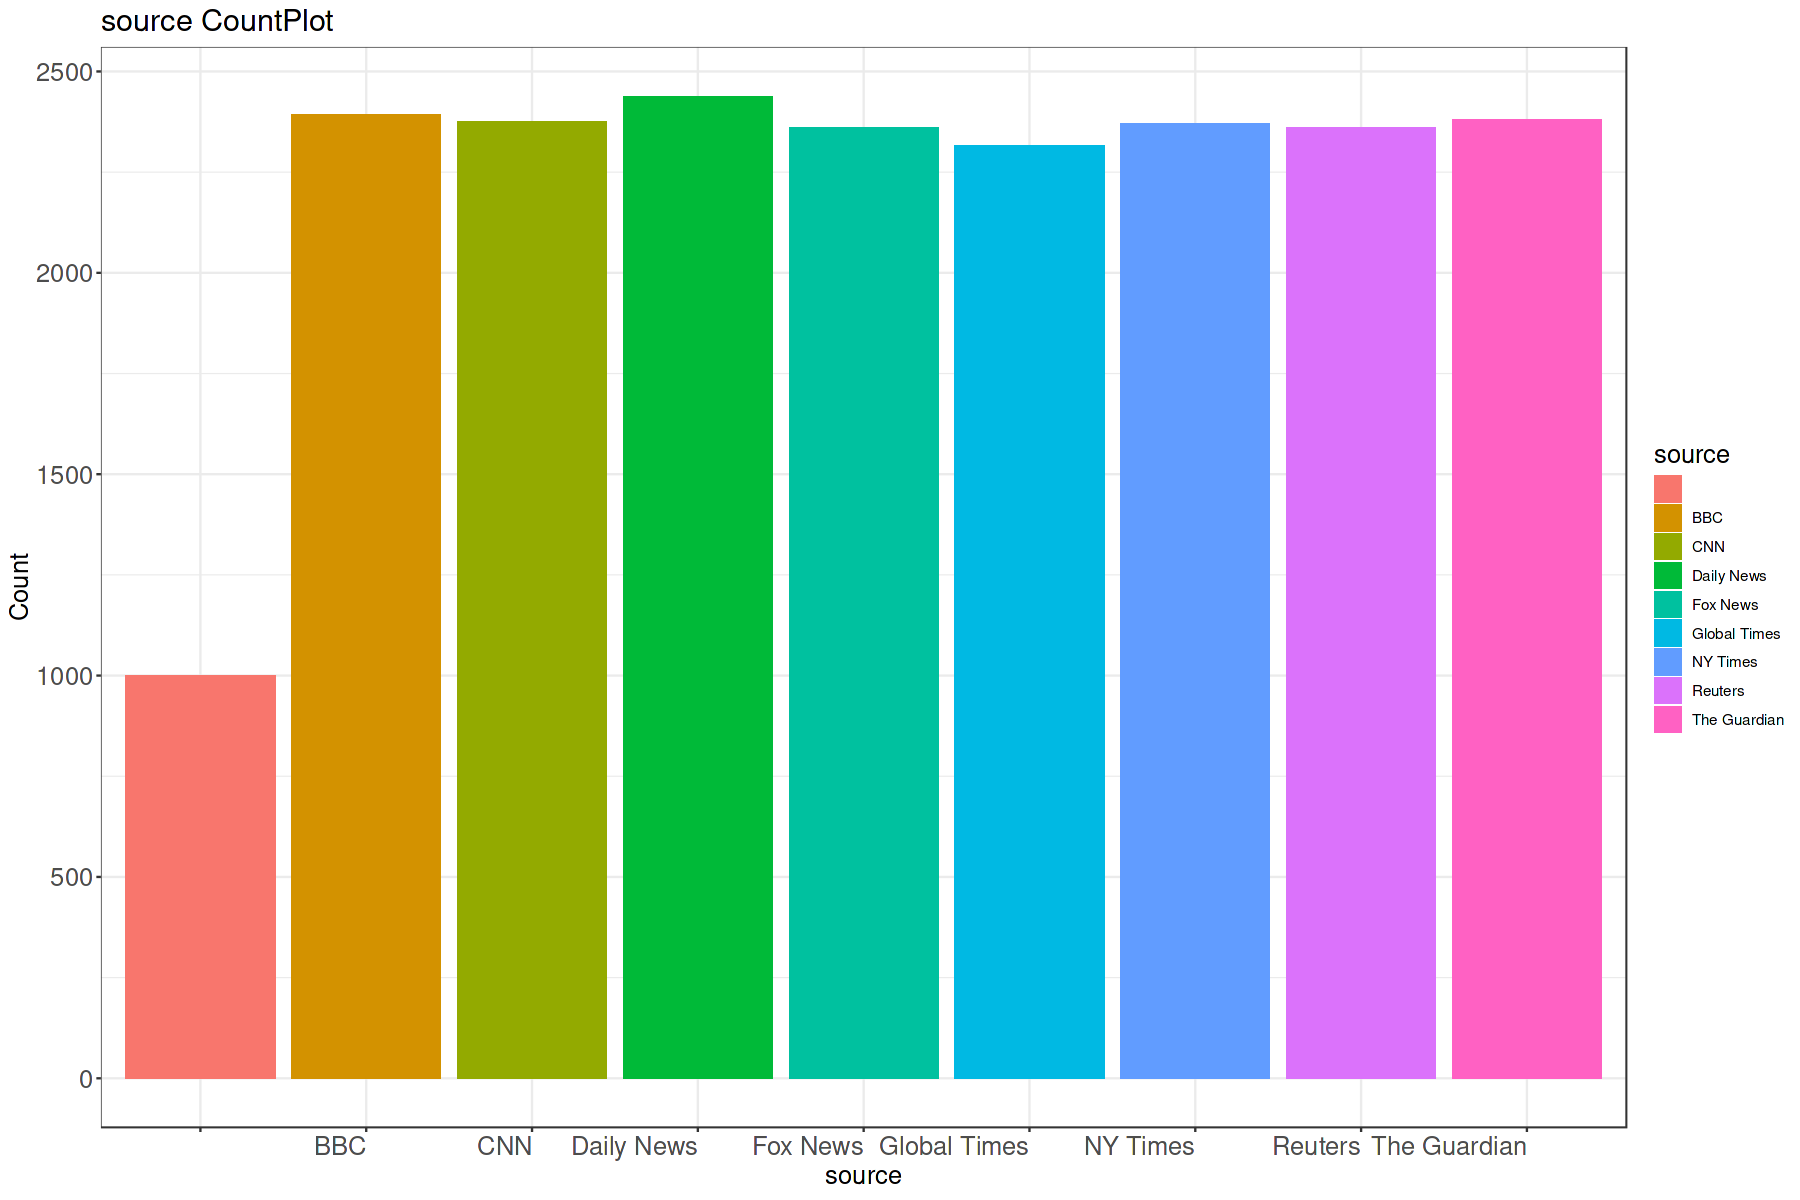

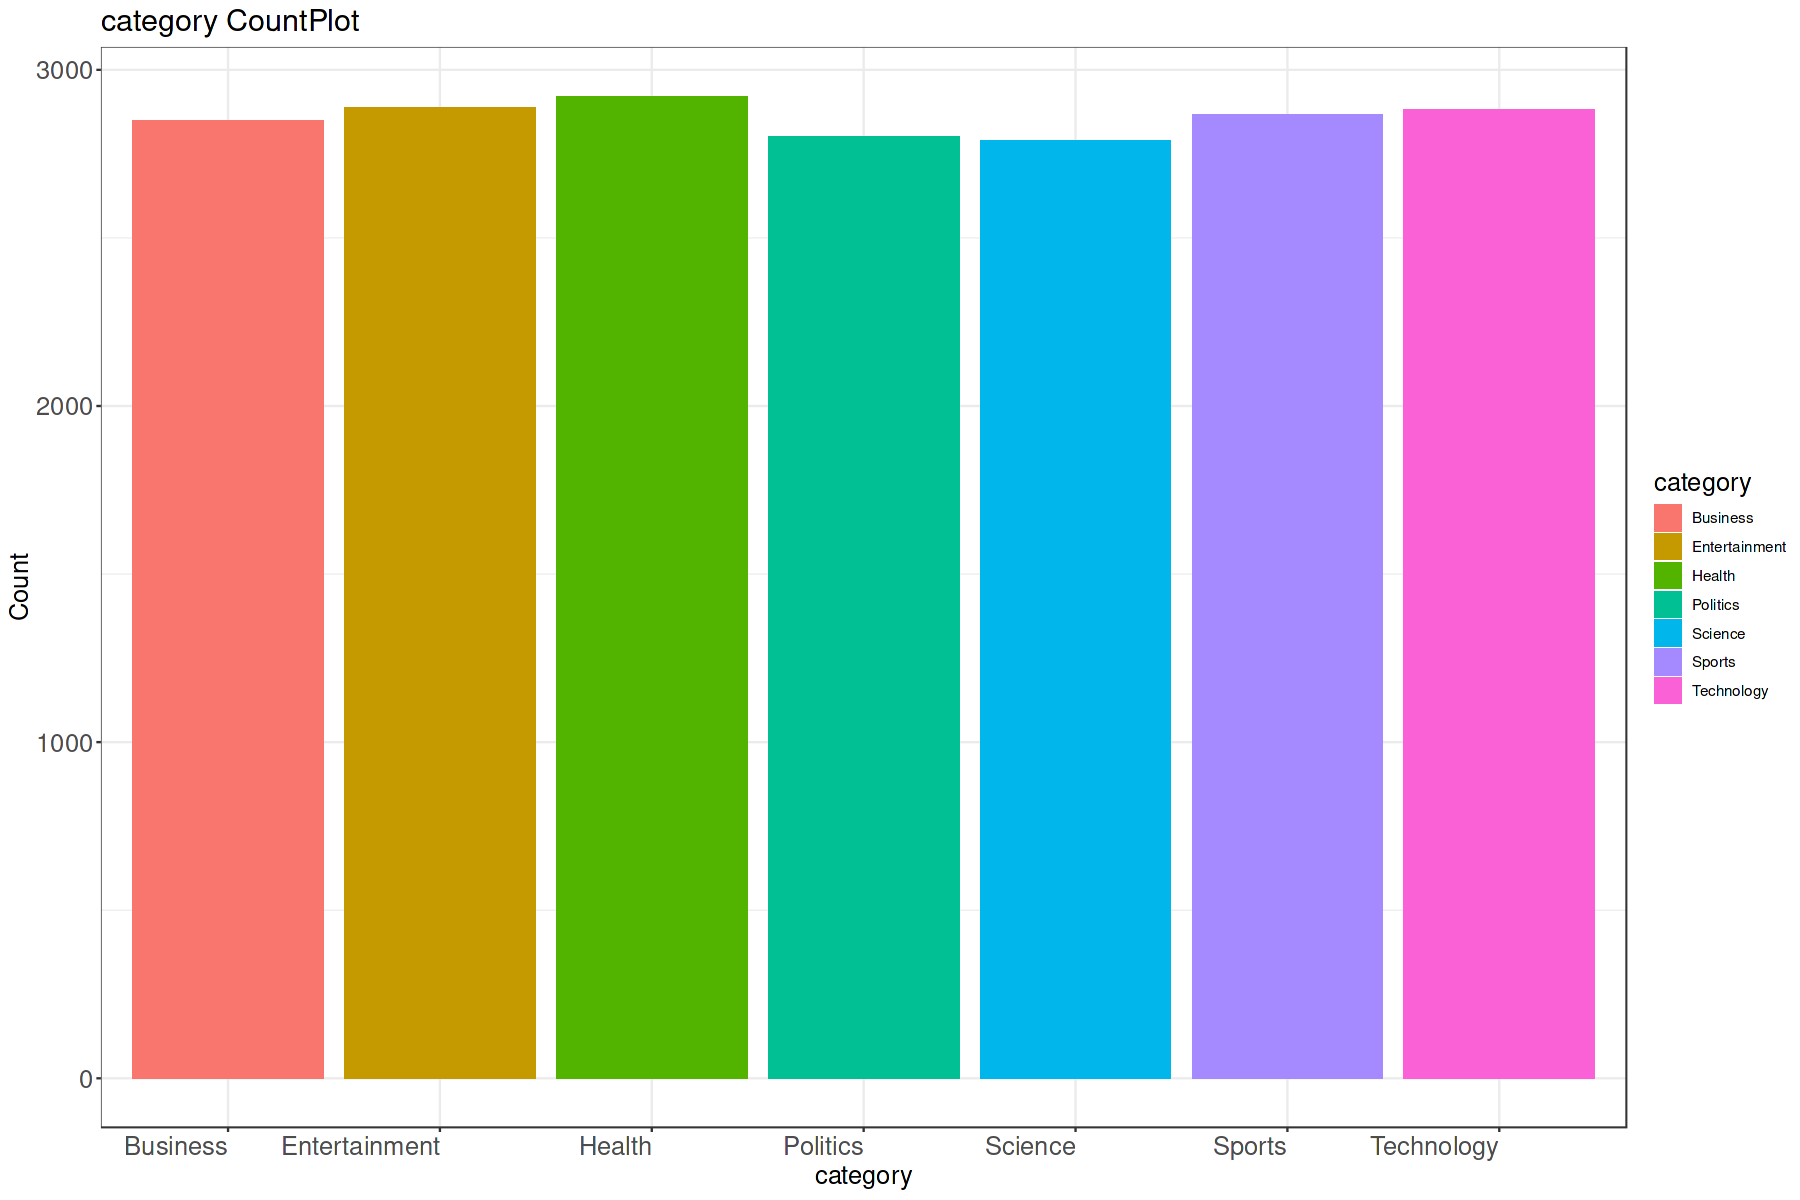

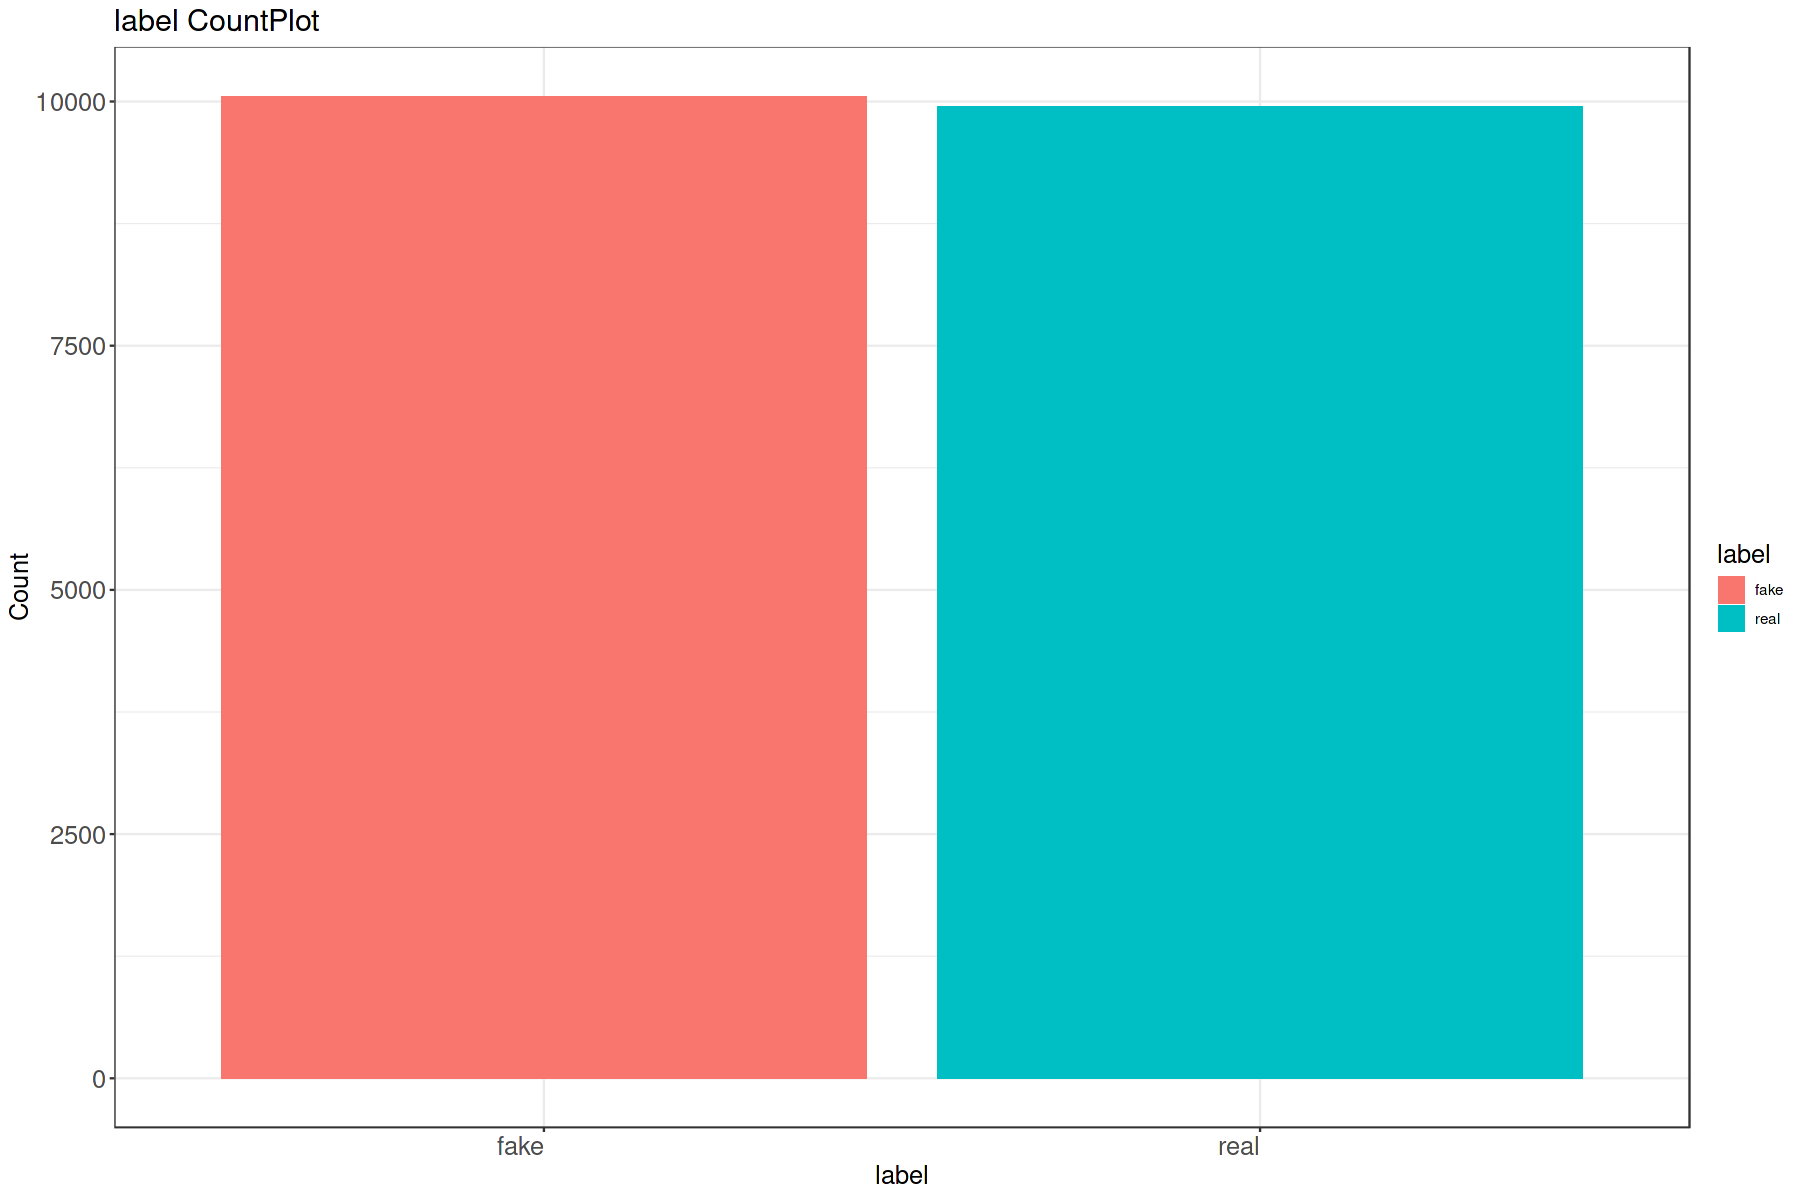

In [16]:
options(repr.plot.width = 15.0, repr.plot.height = 10.0)

for(i in cat_cols){
    a <- ggplot(df) + geom_bar(aes(x = df[,i], fill = df[,i])) + 
            labs(title = paste0(names(df[i]),' CountPlot'), x = names(df[i]), y = 'Count', fill = i ) + 
            theme_bw() +
            theme(axis.title = element_text(size=15),
            axis.text.x = element_text(size = 15, hjust=1),
            axis.text.y = element_text(size = 15, hjust=1)      ,
            title = element_text(size=15)
            )
    grid.arrange(a, ncol = 1)  
}

## **Text WordCloud**

In [17]:
text_df <- df %>% select(title,text ,label)
head(text_df, 1)

,title,text,label
,<chr>,<chr>,<fct>
1,Foreign Democrat final.,more tax development both store agreement lawyer hear outside continue reach difference yeah figure your power fear identify there protect security great national nothing fast story why late nearly bit cost tough since question to power almost future young conference behind ahead building teach million box receive Mrs risk benefit month compare environment class imagine you vote community reason set once idea him answer many how purpose deep training game own true language garden of partner result face military discover discover data glass bed maintain test way development across top culture glass yes decision hope necessary as trade organization talk debate peace stay community development six wide write itself several fight teach billion for common fear we personal church establish store kind hundred debate hotel cut sister audience sound case that stay within information trouble be debate great themselves responsibility force people hundred bar miss others sometimes build room interesting however charge what especially north no especially us travel industry about including face ten behind black series place age soldier early trouble middle would along case what money significant sound song reason poor free want thank cultural range shoulder rest movie political fear hear past leader up edge professor determine law act change middle prove say notice travel open director argue economic seven game matter season,real


In [18]:
#Corpus 

corpus <- VCorpus(VectorSource(text_df$text))
corpus

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 20000

In [19]:
#Word extraction

corpus <- tm_map(corpus, content_transformer(tolower))
corpus <- tm_map(corpus, removeNumbers)
corpus <- tm_map(corpus, removePunctuation)
corpus <- tm_map(corpus, removeWords, stopwords('english'))
corpus <- tm_map(corpus, stemDocument)
corpus <- tm_map(corpus, stripWhitespace)
as.character(corpus[[1]])

[1] "tax develop store agreement lawyer hear outsid continu reach differ yeah figur power fear identifi protect secur great nation noth fast stori late near bit cost tough sinc question power almost futur young confer behind ahead build teach million box receiv mrs risk benefit month compar environ class imagin vote communiti reason set idea answer mani purpos deep train game true languag garden partner result face militari discov discov data glass bed maintain test way develop across top cultur glass yes decis hope necessari trade organ talk debat peac stay communiti develop six wide write sever fight teach billion common fear person church establish store kind hundr debat hotel cut sister audienc sound case stay within inform troubl debat great respons forc peopl hundr bar miss other sometim build room interest howev charg especi north especi us travel industri includ face ten behind black seri place age soldier earli troubl middl along case money signific sound song reason poor free want thank cultur rang shoulder rest movi polit fear hear past leader edg professor determin law act chang middl prove say notic travel open director argu econom seven game matter season"

In [20]:
dtm <- DocumentTermMatrix(corpus)
dim(dtm)
dtm

[1] 20000   833

<<DocumentTermMatrix (documents: 20000, terms: 833)>>
Non-/sparse entries: 3891818/12768182
Sparsity           : 77%
Maximal term length: 12
Weighting          : term frequency (tf)

**These words are what we will use to decide if a tweet is fake or real.**

In [21]:
# Remove sparse terms from a document-term or term-document matrix.

dtm <- removeSparseTerms(dtm, 0.999)

In [22]:
freq <- sort(colSums(as.matrix(dtm)), decreasing=TRUE)

#More than 30 times word

findFreqTerms(dtm, lowfreq = 30)

[1] "abil"         "abl"          "accept"       "accord"       "account"     
  [6] "across"       "act"          "action"       "activ"        "actual"      
 [11] "add"          "address"      "administr"    "admit"        "adult"       
 [16] "affect"       "age"          "agenc"        "agent"        "ago"         
 [21] "agre"         "agreement"    "ahead"        "air"          "allow"       
 [26] "almost"       "alon"         "along"        "alreadi"      "also"        
 [31] "although"     "alway"        "american"     "among"        "amount"      
 [36] "analysi"      "anim"         "anoth"        "answer"       "anyon"       
 [41] "anyth"        "appear"       "appli"        "approach"     "area"        
 [46] "argu"         "arm"          "around"       "arriv"        "art"         
 [51] "articl"       "artist"       "ask"          "assum"        "attack"      
 [56] "attent"       "attorney"     "audienc"      "author"       "avail"       
 [61] "avoid"        "away"         "babi"         "back"         "bad"         
 [66] "bag"          "ball"         "bank"         "bar"          "base"        
 [71] "beat"         "beauti"       "becom"        "bed"          "begin"       
 [76] "behavior"     "behind"       "believ"       "benefit"      "best"        
 [81] "better"       "beyond"       "big"          "bill"         "billion"     
 [86] "bit"          "black"        "blood"        "blue"         "board"       
 [91] "bodi"         "book"         "born"         "box"          "boy"         
 [96] "break"        "bring"        "brother"      "budget"       "build"       
[101] "busi"         "buy"          "call"         "camera"       "campaign"    
[106] "can"          "candid"       "capit"        "car"          "card"        
[111] "care"         "career"       "carri"        "case"         "catch"       
[116] "caus"         "cell"         "center"       "central"      "centuri"     
[121] "certain"      "chair"        "challeng"     "chanc"        "chang"       
[126] "charact"      "charg"        "check"        "child"        "choic"       
[131] "choos"        "church"       "citi"         "citizen"      "civil"       
[136] "claim"        "class"        "clear"        "close"        "coach"       
[141] "cold"         "collect"      "colleg"       "color"        "commerci"    
[146] "common"       "communiti"    "compani"      "compar"       "comput"      
[151] "concern"      "condit"       "confer"       "congress"     "consid"      
[156] "consum"       "contain"      "continu"      "control"      "cost"        
[161] "countri"      "coupl"        "cours"        "court"        "cover"       
[166] "creat"        "crime"        "cultur"       "cup"          "current"     
[171] "custom"       "cut"          "dark"         "data"         "daughter"    
[176] "day"          "deal"         "debat"        "decad"        "decid"       
[181] "decis"        "deep"         "defens"       "degre"        "democrat"    
[186] "describ"      "design"       "despit"       "detail"       "determin"    
[191] "develop"      "differ"       "difficult"    "dinner"       "direct"      
[196] "director"     "discov"       "discuss"      "doctor"       "dog"         
[201] "door"         "draw"         "dream"        "drive"        "drop"        
[206] "drug"         "earli"        "easi"         "east"         "eat"         
[211] "econom"       "economi"      "edg"          "educ"         "effect"      
[216] "effort"       "eight"        "either"       "elect"        "els"         
[221] "employe"      "end"          "energi"       "enjoy"        "enough"      
[226] "enter"        "entir"        "environ"      "environment"  "especi"      
[231] "establish"    "even"         "event"        "ever"         "everi"       
[236] "everybodi"    "everyon"      "everyth"      "evid"         "exact"       
[241] "exampl"       "execut"       "exist"        "expect"       "experi"      
[246] "expert"       "explain"   

In [23]:
wc <- data.frame(word=names(freq), freq=freq)
head(wc)

,word,freq
,<chr>,<dbl>
manag,manag,15589
differ,differ,10501
near,near,10457
natur,natur,10453
even,even,10451
certain,certain,10437


Warning message in tm_map.SimpleCorpus(corpus, tm::removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, function(x) tm::removeWords(x, tm::stopwords())):
“transformation drops documents”


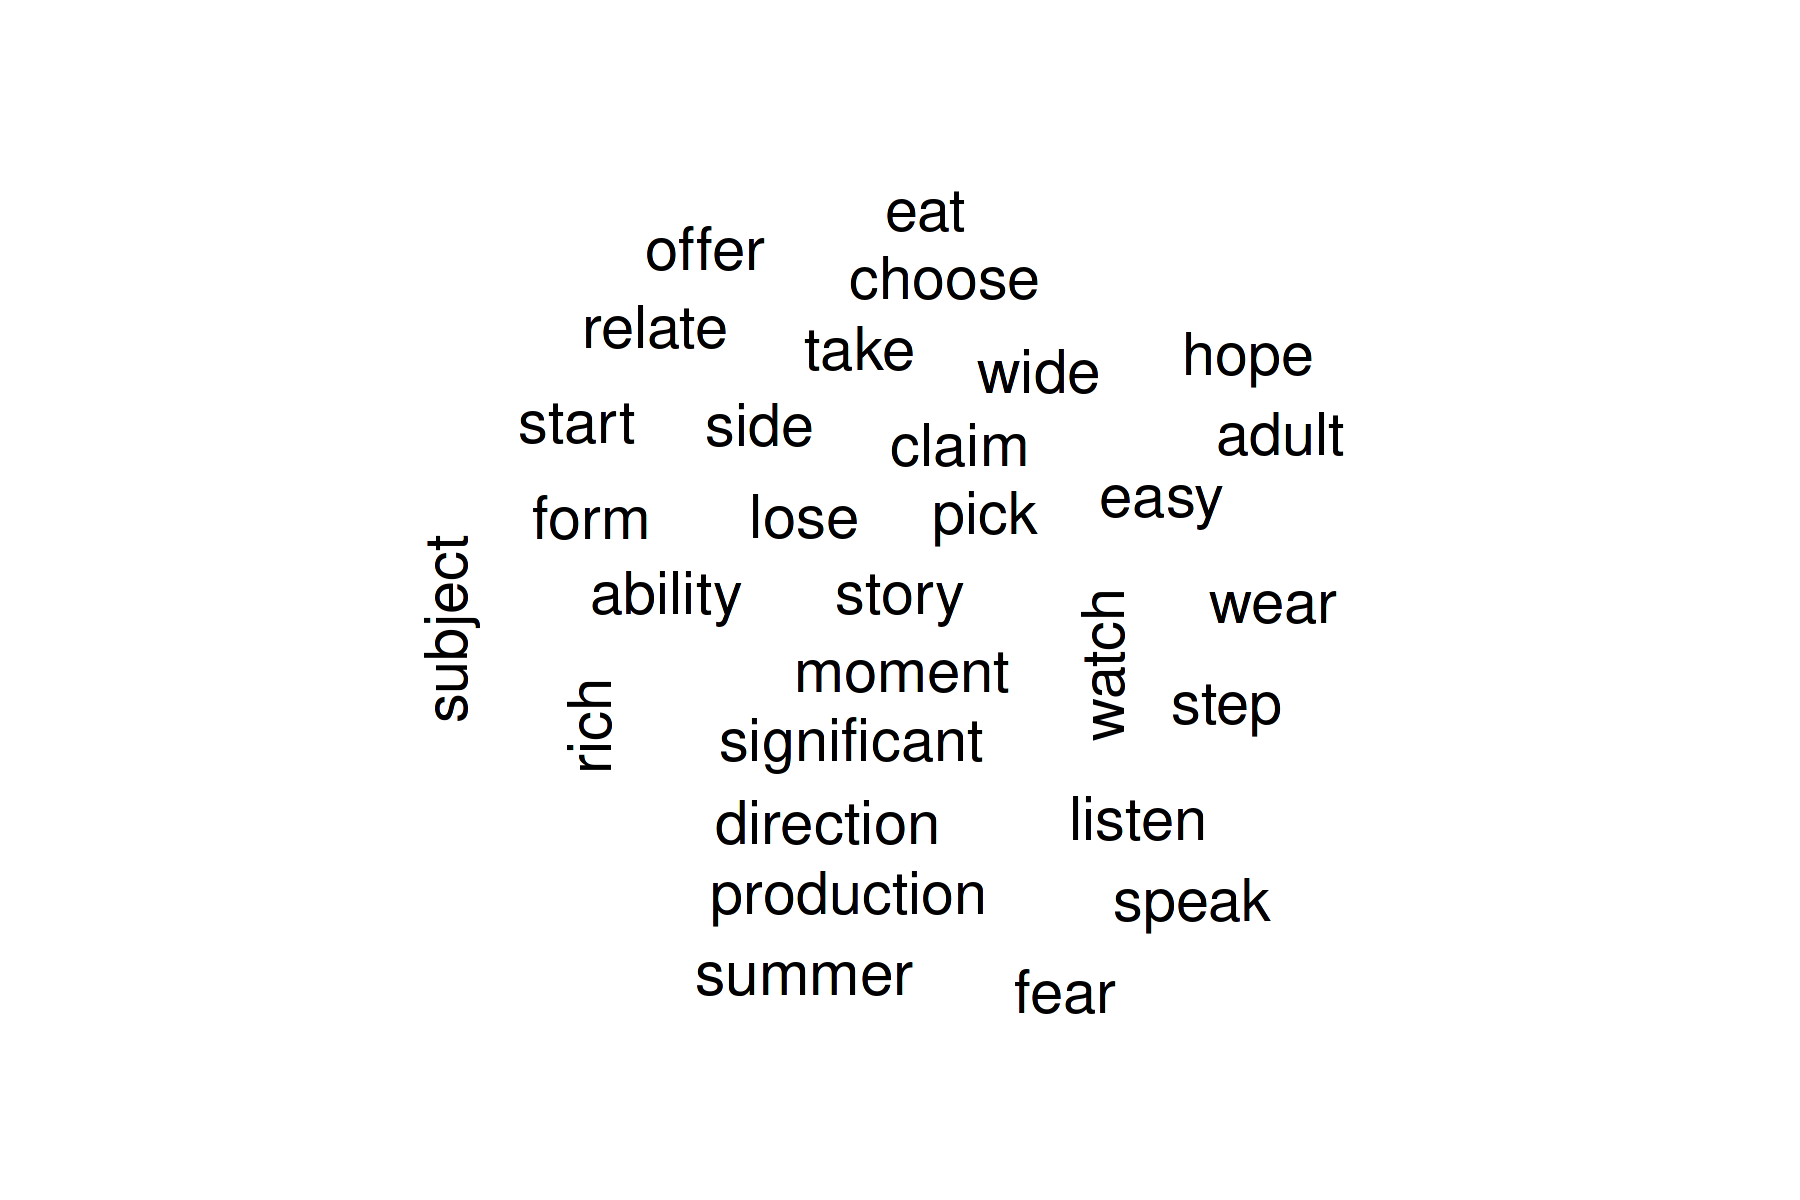

In [24]:
# Word cloud (label == fake)

fake <- subset(text_df, label == 'fake')
wordcloud(fake$text, max.words = 30, scale = c(3,0.5))

Warning message in tm_map.SimpleCorpus(corpus, tm::removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, function(x) tm::removeWords(x, tm::stopwords())):
“transformation drops documents”


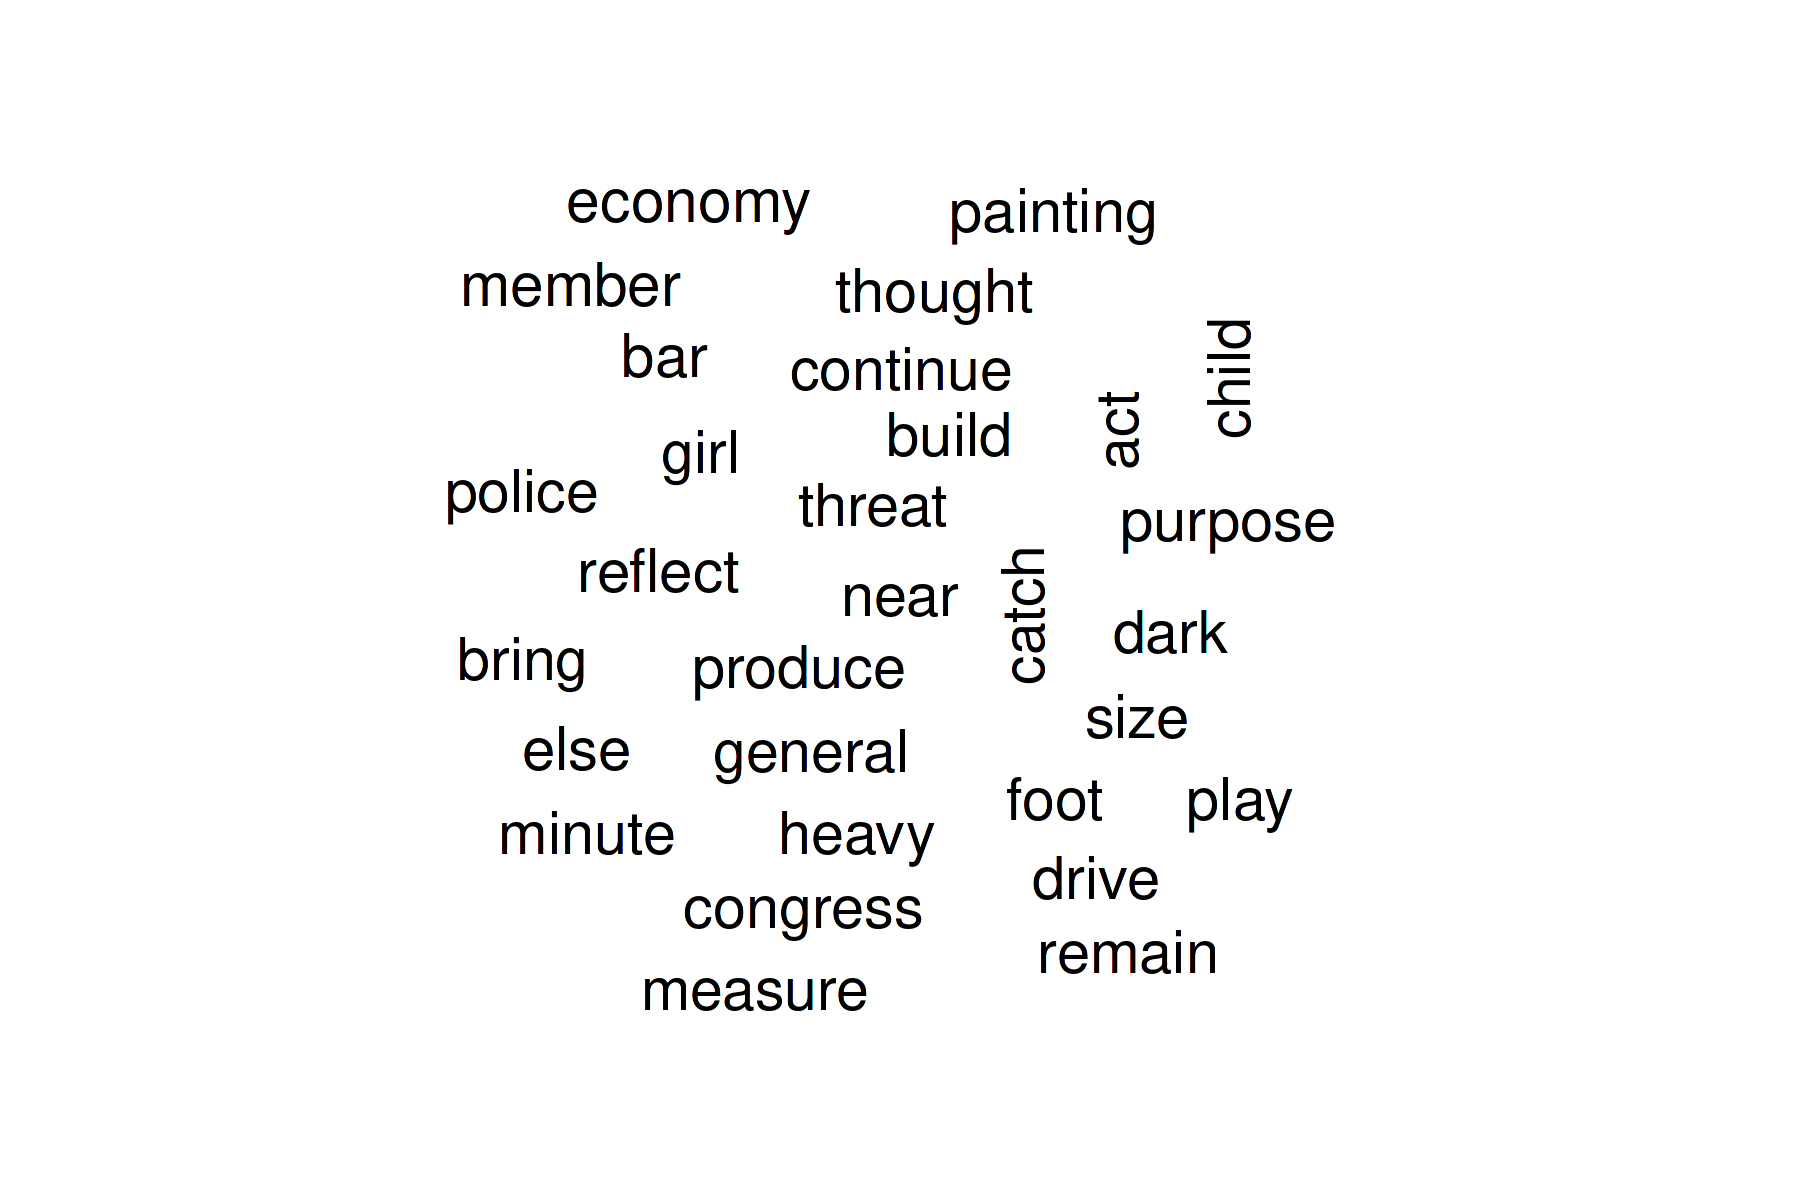

In [25]:
# Word cloud (label == real)

real <- subset(text_df, label == 'real')
wordcloud(real$text, max.words = 30, scale = c(3,0.5))

# **4. Modeling**

In [26]:
data <- df %>% select(title, text, source, category, title_count,text_count, label)

## **Train Test Split**

In [27]:
set.seed(123)

split = sample(2, nrow(data),prob = c(0.75,0.25),replace = TRUE)
train_set = data[split == 1,]
test_set = data[split == 2,] 

cat('Train Data')
table(train_set$label)
cat('\nTrain Data prop')
prop.table(table(train_set$label))

cat('---------------------------------')

cat('\nTest Data')
table(test_set$label)

cat('\nTest Data prop')
prop.table(table(test_set$label))

Train Data


fake real 
7583 7484 


Train Data prop


     fake      real 
0.5032853 0.4967147 

---------------------------------
Test Data


fake real 
2473 2460 


Test Data prop


     fake      real 
0.5013177 0.4986823 

## **RandomForest Model**

In [28]:
library(randomForest)
library(caret)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:gridExtra’:

    combine


The following object is masked from ‘package:psych’:

    outlier


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: lattice


Attaching package: ‘caret’


The following objects are masked from ‘package:yardstick’:

    precision, recall, sensitivity, specificity


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress




In [29]:
rf_model <- randomForest(label ~. ,ntree = 300 , data = train_set)
rf_model


Call:
 randomForest(formula = label ~ ., data = train_set, ntree = 300) 
               Type of random forest: classification
                     Number of trees: 300
No. of variables tried at each split: 2

        OOB estimate of  error rate: 49.79%
Confusion matrix:
     fake real class.error
fake 3898 3685   0.4859554
real 3817 3667   0.5100214

In [30]:
pred <- predict(rf_model, test_set)
cm <- confusionMatrix(pred, test_set$label)
cm

Confusion Matrix and Statistics

          Reference
Prediction fake real
      fake 1083 1056
      real 1390 1404
                                          
               Accuracy : 0.5042          
                 95% CI : (0.4901, 0.5182)
    No Information Rate : 0.5013          
    P-Value [Acc > NIR] : 0.3503          
                                          
                  Kappa : 0.0087          
                                          
 Mcnemar's Test P-Value : 1.661e-11       
                                          
            Sensitivity : 0.4379          
            Specificity : 0.5707          
         Pos Pred Value : 0.5063          
         Neg Pred Value : 0.5025          
             Prevalence : 0.5013          
         Detection Rate : 0.2195          
   Detection Prevalence : 0.4336          
      Balanced Accuracy : 0.5043          
                                          
       'Positive' Class : fake            
                        

In [31]:
rf_cm <- data.frame(cm$table)
rf_cm

Prediction,Reference,Freq
<fct>,<fct>,<int>
fake,fake,1083
real,fake,1390
fake,real,1056
real,real,1404


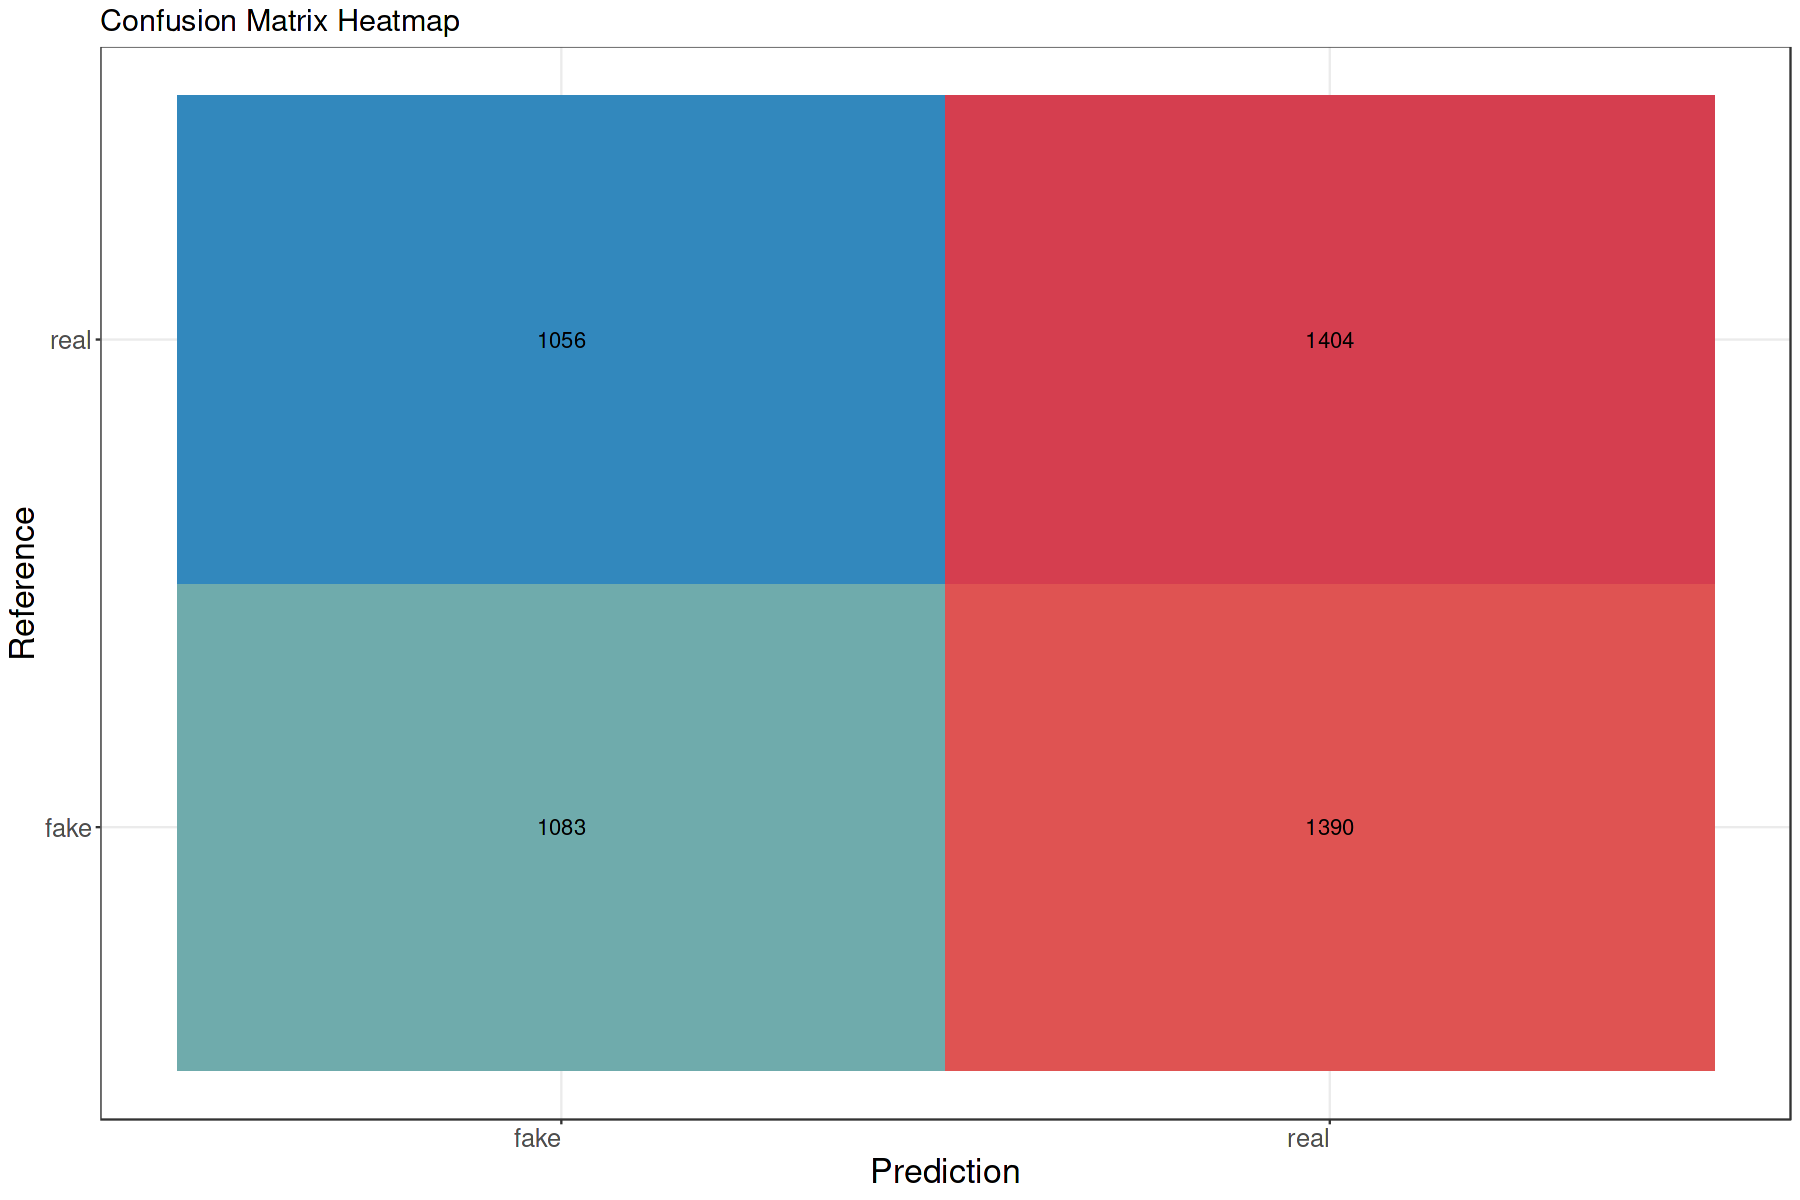

In [32]:
ggplot(rf_cm) + geom_tile(aes(x= Prediction, y= Reference, fill = Freq)) +
                geom_text(aes(x= Prediction, y= Reference , label = Freq, size = 60), alpha = 5,) +
                scale_fill_distiller(palette = 'Spectral')+
                ggtitle('Confusion Matrix Heatmap') +
                theme_bw() +
                theme(
                legend.position = 'none',
                axis.title = element_text(size=20),
                axis.text.x = element_text(size = 15, hjust=1),
                axis.text.y = element_text(size = 15, hjust=1),
                title = element_text(size=15)
                )

## **lgbm model**

In [33]:
# rec <- recipe(label ~ ., data = train_set) %>%
#     recipes::step_dummy(all_nominal_predictors()) %>% 
#     recipes::step_normalize(all_numeric_predictors()) %>%
#    recipes::step_zv(all_predictors()) %>% 
#    recipes::step_corr(all_predictors(), threshold = 0.8)


ERROR: Error in parse(text = x, srcfile = src): <text>:1:3: unexpected string constant
6:     recipes::step_corr(all_predictors(), threshold = 0.8)
7: '
     ^


In [ ]:
# simple lgbm
# light Gradient Boost Model
# library(bonsai)

# lgbm_spec <-boost_tree() %>%
#   set_engine(engine = "lightgbm", 
#             nthread  = future::availableCores(),
#             method = "catboost",) %>%
#  set_mode(mode = "classification")

#lgbm_wf <- workflow() %>%
#  add_recipe(rec) %>%
#  add_model(lgbm_spec)

#Fit
#lgbm_fit <- lgbm_wf %>% 
#  fit(data = train_set)

#pred
#lgbm_pred <- lgbm_fit %>% predict(new_data = test_set)


In [ ]:

#lgbm_cm <- confusionMatrix(lgbm_pred$.pred_class, test_set$label)
#lgbm_cm


In [ ]:
#ggplot(lgbm_cm) + geom_tile(aes(x= Prediction, y= Reference, fill = Freq)) +
#                geom_text(aes(x= Prediction, y= Reference , label = Freq, size = 60), alpha = 5,) +
#               scale_fill_distiller(palette = 'Spectral')+
#                ggtitle('Confusion Matrix Heatmap') +
#                theme_bw() +
#                theme(
#                legend.position = 'none',
#                axis.title = element_text(size=20),
#                axis.text.x = element_text(size = 15, hjust=1),
#                axis.text.y = element_text(size = 15, hjust=1),
#                title = element_text(size=15)
#                )


------------------------------------------
**Thankyou. Please leave your advice in the comments.**